In [1]:
! pip install keras

In [2]:
! pip install tensorflow

# Load python packages

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import functions as fun
import deep_learning_helper as dp
import keras
import tensorflow as tf
import sklearn

%load_ext autoreload 
%autoreload 2

from keras import models
from tensorflow.keras import layers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data 

In [4]:
# load the dataset
dataset = pd.read_csv('training_data.csv')
# dropp unncecassary columns
dataset = dataset.drop(['Unnamed: 0'], axis = 1)
dataset.head()

epoch_utc  emission_factor                datetime_de  windon_forecast  \
0  1.546297e+09       298.240217  2018-12-31 23:00:00+00:00         18879.75   
1  1.546301e+09       266.522473  2019-01-01 00:00:00+00:00         20626.50   
2  1.546304e+09       262.594215  2019-01-01 01:00:00+00:00         22355.50   
3  1.546308e+09       260.190772  2019-01-01 02:00:00+00:00         24032.50   
4  1.546312e+09       250.496683  2019-01-01 03:00:00+00:00         25452.00   

   windoff_forecast  solar_forecast  prices_forecast  \
0           5069.00             0.0            28.32   
1           5042.25             0.0            10.07   
2           5028.50             0.0            -4.08   
3           4977.75             0.0            -9.91   
4           4907.25             0.0            -7.41   

   aggregated_generation_forecast  AT_import  AT_export  ...  DK_import  \
0                         57054.0       61.0     4940.0  ...      901.0   
1                         57400.0       60.0     5073.0  ...      316.0   
2                         57275.0       20.0     4284.0  ...        0.0   
3                         58024.0        3.0     4273.0  ...        0.0   
4                         59301.0        0.0     4961.0  ...        0.0   

   DK_export  LU_import  LU_export  NL_import  NL_export  PL_import  \
0        0.0       12.0      418.0        0.0     1354.0      224.0   
1        0.0       16.0      398.0        0.0     1158.0        0.0   
2      405.0       19.0      379.0        0.0     1176.0        0.0   
3      619.0       23.0      373.0        0.0     1428.0        0.0   
4      689.0       27.0      370.0        0.0     1492.0        0.0   

   PL_export  CH_import  CH_export  
0        0.0        0.0      800.0  
1        0.0        1.0      801.0  
2        0.0        0.0      800.0  
3        0.0        0.0      800.0  
4        0.0        0.0      800.0  

[5 rows x 22 columns]

In [5]:
# Split dataset int targe = co2 emisssions and features

# get co2 emissions
co2 = dataset['emission_factor']

# get features
cols_features = [c for c in dataset.columns if c != 'emission_factor']
cols = {c: i for i, c in enumerate(dataset.columns)}
indices = {ind: i for i, ind in enumerate(dataset.index)}
features = dataset.loc[:, [j for j in cols if j != 'emission_factor' and j in cols_features]]

In [6]:
# check co2 data
co2.head()

0    298.240217
1    266.522473
2    262.594215
3    260.190772
4    250.496683
Name: emission_factor, dtype: float64

In [7]:
# check features
features.head()

epoch_utc                datetime_de  windon_forecast  windoff_forecast  \
0  1.546297e+09  2018-12-31 23:00:00+00:00         18879.75           5069.00   
1  1.546301e+09  2019-01-01 00:00:00+00:00         20626.50           5042.25   
2  1.546304e+09  2019-01-01 01:00:00+00:00         22355.50           5028.50   
3  1.546308e+09  2019-01-01 02:00:00+00:00         24032.50           4977.75   
4  1.546312e+09  2019-01-01 03:00:00+00:00         25452.00           4907.25   

   solar_forecast  prices_forecast  aggregated_generation_forecast  AT_import  \
0             0.0            28.32                         57054.0       61.0   
1             0.0            10.07                         57400.0       60.0   
2             0.0            -4.08                         57275.0       20.0   
3             0.0            -9.91                         58024.0        3.0   
4             0.0            -7.41                         59301.0        0.0   

   AT_export  CZ_import  ...  DK_import  DK_export  LU_import  LU_export  \
0     4940.0     1076.0  ...      901.0        0.0       12.0      418.0   
1     5073.0      514.0  ...      316.0        0.0       16.0      398.0   
2     4284.0        0.0  ...        0.0      405.0       19.0      379.0   
3     4273.0      111.0  ...        0.0      619.0       23.0      373.0   
4     4961.0        0.0  ...        0.0      689.0       27.0      370.0   

   NL_import  NL_export  PL_import  PL_export  CH_import  CH_export  
0        0.0     1354.0      224.0        0.0        0.0      800.0  
1        0.0     1158.0        0.0        0.0        1.0      801.0  
2        0.0     1176.0        0.0        0.0        0.0      800.0  
3        0.0     1428.0        0.0        0.0        0.0      800.0  
4        0.0     1492.0        0.0        0.0        0.0      800.0  

[5 rows x 21 columns]

## Feature Enginnering

### Create lagged features

In [8]:
# create 26 laggs of the co2 emission factor

co2_lag = fun.make_lags(co2, lags = 26)
co2_lag = co2_lag.fillna(0.0)
co2_lag.head()

y_lag_1     y_lag_2     y_lag_3     y_lag_4  y_lag_5  y_lag_6  y_lag_7  \
0    0.000000    0.000000    0.000000    0.000000      0.0      0.0      0.0   
1  298.240217    0.000000    0.000000    0.000000      0.0      0.0      0.0   
2  266.522473  298.240217    0.000000    0.000000      0.0      0.0      0.0   
3  262.594215  266.522473  298.240217    0.000000      0.0      0.0      0.0   
4  260.190772  262.594215  266.522473  298.240217      0.0      0.0      0.0   

   y_lag_8  y_lag_9  y_lag_10  ...  y_lag_17  y_lag_18  y_lag_19  y_lag_20  \
0      0.0      0.0       0.0  ...       0.0       0.0       0.0       0.0   
1      0.0      0.0       0.0  ...       0.0       0.0       0.0       0.0   
2      0.0      0.0       0.0  ...       0.0       0.0       0.0       0.0   
3      0.0      0.0       0.0  ...       0.0       0.0       0.0       0.0   
4      0.0      0.0       0.0  ...       0.0       0.0       0.0       0.0   

   y_lag_21  y_lag_22  y_lag_23  y_lag_24  y_lag_25  y_lag_26  
0       0.0       0.0       0.0       0.0       0.0       0.0  
1       0.0       0.0       0.0       0.0       0.0       0.0  
2       0.0       0.0       0.0       0.0       0.0       0.0  
3       0.0       0.0       0.0       0.0       0.0       0.0  
4       0.0       0.0       0.0       0.0       0.0       0.0  

[5 rows x 26 columns]

In [9]:
# add lag 24 and 26 to the features

features[['co2_24_lag','co2_26_lag']] = co2_lag[['y_lag_24','y_lag_26']].set_index(features.index)
features.head()

epoch_utc                datetime_de  windon_forecast  windoff_forecast  \
0  1.546297e+09  2018-12-31 23:00:00+00:00         18879.75           5069.00   
1  1.546301e+09  2019-01-01 00:00:00+00:00         20626.50           5042.25   
2  1.546304e+09  2019-01-01 01:00:00+00:00         22355.50           5028.50   
3  1.546308e+09  2019-01-01 02:00:00+00:00         24032.50           4977.75   
4  1.546312e+09  2019-01-01 03:00:00+00:00         25452.00           4907.25   

   solar_forecast  prices_forecast  aggregated_generation_forecast  AT_import  \
0             0.0            28.32                         57054.0       61.0   
1             0.0            10.07                         57400.0       60.0   
2             0.0            -4.08                         57275.0       20.0   
3             0.0            -9.91                         58024.0        3.0   
4             0.0            -7.41                         59301.0        0.0   

   AT_export  CZ_import  ...  LU_import  LU_export  NL_import  NL_export  \
0     4940.0     1076.0  ...       12.0      418.0        0.0     1354.0   
1     5073.0      514.0  ...       16.0      398.0        0.0     1158.0   
2     4284.0        0.0  ...       19.0      379.0        0.0     1176.0   
3     4273.0      111.0  ...       23.0      373.0        0.0     1428.0   
4     4961.0        0.0  ...       27.0      370.0        0.0     1492.0   

   PL_import  PL_export  CH_import  CH_export  co2_24_lag  co2_26_lag  
0      224.0        0.0        0.0      800.0         0.0         0.0  
1        0.0        0.0        1.0      801.0         0.0         0.0  
2        0.0        0.0        0.0      800.0         0.0         0.0  
3        0.0        0.0        0.0      800.0         0.0         0.0  
4        0.0        0.0        0.0      800.0         0.0         0.0  

[5 rows x 23 columns]

### Create temproal features

In [10]:
# get datetime type timestemps from fetures
date =pd.to_datetime(features.datetime_de)

In [11]:
# one hot encoding of timestemps of features

features['hour_of_day'] = date.dt.hour # get hour of the given day
features['day_of_week'] = date.dt.weekday # get day of current weak
features['hour_of_year'] = ((date.dt.dayofyear-1) * 24) + date.dt.hour # get hour of current year
features = features.drop(columns=['datetime_de', 'epoch_utc']) # drop the timestemps
features.head()

windon_forecast  windoff_forecast  solar_forecast  prices_forecast  \
0         18879.75           5069.00             0.0            28.32   
1         20626.50           5042.25             0.0            10.07   
2         22355.50           5028.50             0.0            -4.08   
3         24032.50           4977.75             0.0            -9.91   
4         25452.00           4907.25             0.0            -7.41   

   aggregated_generation_forecast  AT_import  AT_export  CZ_import  CZ_export  \
0                         57054.0       61.0     4940.0     1076.0      569.0   
1                         57400.0       60.0     5073.0      514.0      694.0   
2                         57275.0       20.0     4284.0        0.0      685.0   
3                         58024.0        3.0     4273.0      111.0     1186.0   
4                         59301.0        0.0     4961.0        0.0     1122.0   

   DK_import  ...  NL_export  PL_import  PL_export  CH_import  CH_export  \
0      901.0  ...     1354.0      224.0        0.0        0.0      800.0   
1      316.0  ...     1158.0        0.0        0.0        1.0      801.0   
2        0.0  ...     1176.0        0.0        0.0        0.0      800.0   
3        0.0  ...     1428.0        0.0        0.0        0.0      800.0   
4        0.0  ...     1492.0        0.0        0.0        0.0      800.0   

   co2_24_lag  co2_26_lag  hour_of_day  day_of_week  hour_of_year  
0         0.0         0.0           23            0          8759  
1         0.0         0.0            0            1             0  
2         0.0         0.0            1            1             1  
3         0.0         0.0            2            1             2  
4         0.0         0.0            3            1             3  

[5 rows x 24 columns]

In [12]:
features['day_of_week'].replace({0: 'mon', 1: 'tue', 2: 'wed', 3: 'thu', 4: 'fri', 5: 'sat', 6: 'sun'}, inplace=True)
features = pd.get_dummies(features, columns=['day_of_week'])
features.head()

windon_forecast  windoff_forecast  solar_forecast  prices_forecast  \
0         18879.75           5069.00             0.0            28.32   
1         20626.50           5042.25             0.0            10.07   
2         22355.50           5028.50             0.0            -4.08   
3         24032.50           4977.75             0.0            -9.91   
4         25452.00           4907.25             0.0            -7.41   

   aggregated_generation_forecast  AT_import  AT_export  CZ_import  CZ_export  \
0                         57054.0       61.0     4940.0     1076.0      569.0   
1                         57400.0       60.0     5073.0      514.0      694.0   
2                         57275.0       20.0     4284.0        0.0      685.0   
3                         58024.0        3.0     4273.0      111.0     1186.0   
4                         59301.0        0.0     4961.0        0.0     1122.0   

   DK_import  ...  co2_26_lag  hour_of_day  hour_of_year  day_of_week_fri  \
0      901.0  ...         0.0           23          8759                0   
1      316.0  ...         0.0            0             0                0   
2        0.0  ...         0.0            1             1                0   
3        0.0  ...         0.0            2             2                0   
4        0.0  ...         0.0            3             3                0   

   day_of_week_mon  day_of_week_sat  day_of_week_sun  day_of_week_thu  \
0                1                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   day_of_week_tue  day_of_week_wed  
0                0                0  
1                1                0  
2                1                0  
3                1                0  
4                1                0  

[5 rows x 30 columns]

In [13]:
# transform hourly features into ciclical data

features_temp = ['hour_of_day', 'hour_of_year']
corr_numbers = [24, 8760]# hours in a day and hours in a year
for f, n in zip(features_temp, corr_numbers):
    features[f + '_sin'] = np.sin(features[f]*(2.*np.pi/n))
    features[f + '_cos'] = np.cos(features[f]*(2.*np.pi/n))
features.drop(columns=features_temp, inplace=True)
features.head()

windon_forecast  windoff_forecast  solar_forecast  prices_forecast  \
0         18879.75           5069.00             0.0            28.32   
1         20626.50           5042.25             0.0            10.07   
2         22355.50           5028.50             0.0            -4.08   
3         24032.50           4977.75             0.0            -9.91   
4         25452.00           4907.25             0.0            -7.41   

   aggregated_generation_forecast  AT_import  AT_export  CZ_import  CZ_export  \
0                         57054.0       61.0     4940.0     1076.0      569.0   
1                         57400.0       60.0     5073.0      514.0      694.0   
2                         57275.0       20.0     4284.0        0.0      685.0   
3                         58024.0        3.0     4273.0      111.0     1186.0   
4                         59301.0        0.0     4961.0        0.0     1122.0   

   DK_import  ...  day_of_week_mon  day_of_week_sat  day_of_week_sun  \
0      901.0  ...                1                0                0   
1      316.0  ...                0                0                0   
2        0.0  ...                0                0                0   
3        0.0  ...                0                0                0   
4        0.0  ...                0                0                0   

   day_of_week_thu  day_of_week_tue  day_of_week_wed  hour_of_day_sin  \
0                0                0                0        -0.258819   
1                0                1                0         0.000000   
2                0                1                0         0.258819   
3                0                1                0         0.500000   
4                0                1                0         0.707107   

   hour_of_day_cos  hour_of_year_sin  hour_of_year_cos  
0         0.965926         -0.000717          1.000000  
1         1.000000          0.000000          1.000000  
2         0.965926          0.000717          1.000000  
3         0.866025          0.001435          0.999999  
4         0.707107          0.002152          0.999998  

[5 rows x 32 columns]

## Creation of MLP

### Train Test Split

In [14]:
# define the percentage of the train set
train_ratio = 0.7
val_ratio = 0.9
n = len(co2)#
assert(n == len(features))

# split the target into train and test set
co2_train = co2[0:int(n*train_ratio)]
co2_train_val = co2[0:int(n*val_ratio)]
co2_val = co2[int(n*train_ratio):int(n*val_ratio)]
co2_test = co2[int(n*val_ratio):]

# split the features into train and test set
features_train = features[0:int(n*train_ratio)]
features_train_val = features[0:int(n*val_ratio)]
features_val = features[int(n*train_ratio):int(n*val_ratio)]
features_test = features[int(n*val_ratio):]

assert( len(co2_train) == len(features_train))
assert( len(co2_train_val) == len(features_train_val))
assert( len(co2_val) == len(features_val))
assert( len(co2_test) == len(features_test))

In [15]:
#get number of features
n_features = len(features.columns)
print(n_features)

32


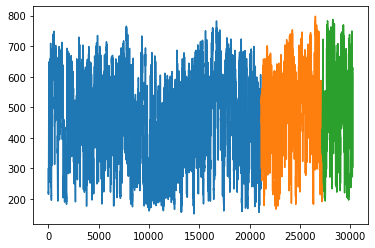

In [16]:
# check the train test split by plotting both

plt.plot(co2_train)
plt.plot(co2_val)
plt.plot(co2_test)
plt.show()

### Create walk forward split

In [17]:
n_val = co2_val.shape[0]
val_split = 8
val_len = n_val // val_split
assert( n_val % val_split == 0)
print('This is the length of the validation data set:', n_val)
print('This is the number of validation splits:', val_split)
print('This is the length of one validation split:', val_len)

This is the length of the validation data set: 6048
This is the number of validation splits: 8
This is the length of one validation split: 756


In [18]:
from sklearn.model_selection import TimeSeriesSplit
# get object that contains split indexes accorcing to the test lenght and the forecast period

#define forecast period
forecast_period = 24
tscv_val = TimeSeriesSplit(gap = 0, test_size= val_len, n_splits = val_split)
tscv_test = TimeSeriesSplit(gap = 0, test_size= forecast_period, n_splits = int(len(co2_test)/forecast_period))

In [19]:
for train_index, test_index in tscv_val.split(co2_train_val):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = features.values[train_index], features.values[test_index]
    y_train, y_test = co2.values[train_index], co2.values[test_index]

TRAIN: [    0     1     2 ... 21164 21165 21166] TEST: [21167 21168 21169 21170 21171 21172 21173 21174 21175 21176 21177 21178
 21179 21180 21181 21182 21183 21184 21185 21186 21187 21188 21189 21190
 21191 21192 21193 21194 21195 21196 21197 21198 21199 21200 21201 21202
 21203 21204 21205 21206 21207 21208 21209 21210 21211 21212 21213 21214
 21215 21216 21217 21218 21219 21220 21221 21222 21223 21224 21225 21226
 21227 21228 21229 21230 21231 21232 21233 21234 21235 21236 21237 21238
 21239 21240 21241 21242 21243 21244 21245 21246 21247 21248 21249 21250
 21251 21252 21253 21254 21255 21256 21257 21258 21259 21260 21261 21262
 21263 21264 21265 21266 21267 21268 21269 21270 21271 21272 21273 21274
 21275 21276 21277 21278 21279 21280 21281 21282 21283 21284 21285 21286
 21287 21288 21289 21290 21291 21292 21293 21294 21295 21296 21297 21298
 21299 21300 21301 21302 21303 21304 21305 21306 21307 21308 21309 21310
 21311 21312 21313 21314 21315 21316 21317 21318 21319 21320 21321 21

In [20]:
co2_train_val.shape, co2_test.shape, co2.shape, co2_val.shape

((27215,), (3024,), (30239,), (6048,))

In [21]:
# check the number of splits for the forward validation
tscv_val.get_n_splits(), tscv_test.get_n_splits()

(8, 126)

In [22]:
# check if the tscv splits align with the test data set
assert(tscv_val.get_n_splits() == co2_val.shape[0] / val_len)
assert(tscv_test.get_n_splits() == co2_test.shape[0] / forecast_period)

### Normalize the data

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
print(co2_train_val.head())
print(features_train_val.shape)
features_train_val.head()

0    298.240217
1    266.522473
2    262.594215
3    260.190772
4    250.496683
Name: emission_factor, dtype: float64
(27215, 32)


windon_forecast  windoff_forecast  solar_forecast  prices_forecast  \
0         18879.75           5069.00             0.0            28.32   
1         20626.50           5042.25             0.0            10.07   
2         22355.50           5028.50             0.0            -4.08   
3         24032.50           4977.75             0.0            -9.91   
4         25452.00           4907.25             0.0            -7.41   

   aggregated_generation_forecast  AT_import  AT_export  CZ_import  CZ_export  \
0                         57054.0       61.0     4940.0     1076.0      569.0   
1                         57400.0       60.0     5073.0      514.0      694.0   
2                         57275.0       20.0     4284.0        0.0      685.0   
3                         58024.0        3.0     4273.0      111.0     1186.0   
4                         59301.0        0.0     4961.0        0.0     1122.0   

   DK_import  ...  day_of_week_mon  day_of_week_sat  day_of_week_sun  \
0      901.0  ...                1                0                0   
1      316.0  ...                0                0                0   
2        0.0  ...                0                0                0   
3        0.0  ...                0                0                0   
4        0.0  ...                0                0                0   

   day_of_week_thu  day_of_week_tue  day_of_week_wed  hour_of_day_sin  \
0                0                0                0        -0.258819   
1                0                1                0         0.000000   
2                0                1                0         0.258819   
3                0                1                0         0.500000   
4                0                1                0         0.707107   

   hour_of_day_cos  hour_of_year_sin  hour_of_year_cos  
0         0.965926         -0.000717          1.000000  
1         1.000000          0.000000          1.000000  
2         0.965926          0.000717          1.000000  
3         0.866025          0.001435          0.999999  
4         0.707107          0.002152          0.999998  

[5 rows x 32 columns]

In [25]:
scaler_co2 =MinMaxScaler()
scaler_features =MinMaxScaler()

In [24]:
scaler_co2 = scaler_co2.fit(co2_train_val.values.reshape(-1, 1))
scaler_features = scaler_features.fit(features_train_val.values)

In [25]:
norm_co2_train_val = scaler_co2.fit_transform(co2_train_val.values.reshape(-1, 1))
norm_features_train_val = scaler_features.fit_transform(features_train_val)
print(norm_co2_train_val)
norm_features_train_val

[[0.2277245 ]
 [0.17870823]
 [0.17263754]
 ...
 [0.41193261]
 [0.39554345]
 [0.37003945]]


array([[0.44624169, 0.74744293, 0.        , ..., 0.98296291, 0.49964137,
        0.99999987],
       [0.48788352, 0.74347762, 0.        , ..., 1.        , 0.5       ,
        1.        ],
       [0.5291022 , 0.74143937, 0.        , ..., 0.98296291, 0.50035863,
        0.99999987],
       ...,
       [0.64492693, 0.81622443, 0.        , ..., 0.62940952, 0.80281349,
        0.89787434],
       [0.62373352, 0.85543285, 0.        , ..., 0.75      , 0.80309879,
        0.89765704],
       [0.60139581, 0.887563  , 0.        , ..., 0.85355339, 0.80338394,
        0.89743954]])

In [26]:
# sanity check

inv_co2_train_val = scaler_co2.inverse_transform(norm_co2_train_val)
inv_features_train_val = scaler_features.inverse_transform(norm_features_train_val)
print(inv_co2_train_val)
print(inv_features_train_val)

[[298.24021746]
 [266.5224729 ]
 [262.59421499]
 ...
 [417.43872498]
 [406.83352639]
 [390.33024424]]
[[ 1.88797500e+04  5.06900000e+03  0.00000000e+00 ...  9.65925826e-01
  -7.17258535e-04  9.99999743e-01]
 [ 2.06265000e+04  5.04225000e+03  0.00000000e+00 ...  1.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 2.23555000e+04  5.02850000e+03  0.00000000e+00 ...  9.65925826e-01
   7.17258535e-04  9.99999743e-01]
 ...
 [ 2.72140000e+04  5.53300000e+03  0.00000000e+00 ...  2.58819045e-01
   6.05626983e-01  7.95748677e-01]
 [ 2.63250000e+04  5.79750000e+03  0.00000000e+00 ...  5.00000000e-01
   6.06197585e-01  7.95314082e-01]
 [ 2.53880000e+04  6.01425000e+03  0.00000000e+00 ...  7.07106781e-01
   6.06767875e-01  7.94879077e-01]]


# Define the Neural Network

In [29]:
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LeakyReLU
#from fun import Dropout
import keras.backend as K
import keras

#### Todos:
# define root mean squared error loss -done
# add probabiltic prediction done
# try out activation laysers -done
# ty out otimizers -done
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [30]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [31]:
learning_rate = 0.001
loss = 'mse'
optimizer = keras.optimizers.Adamax(learning_rate)
activation = 'relu'
dp_rate = 0.2
metrics=[tf.keras.metrics.RootMeanSquaredError()]

In [32]:
model_mlp = dp.MLP(n_features, learning_rate, activation, loss, optimizer, dp_rate, metrics)

In [33]:
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               3

In [34]:
callback = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    verbose = 0,
    patience = 15,
    mode = 'auto',
    restore_best_weights = True
)

In [35]:
from numpy.random import seed

In [36]:
seed(42)
tf.random.set_seed (42)

In [37]:
alpha_low = 0.025
alpha_high = 0.975
lower_val, mean_val, upper_val, report_val = dp.walk_forward_deep_learning(tscv_val, model_mlp, co2_train_val, features_train_val, co2_val, alpha_low, alpha_high,n_features, callback ,learning_rate = learning_rate, loss = loss, optimizer = optimizer,batch_size =16, epochs = 200, num_preds = 100, method = 'MLP', refit = True, validation = True)
print(report_val)

MAE for MLP: 28.65 g_CO2/kWh
MAPE for MLP: 6.36 %
RMSE for MLP: 36.62 g_CO2/kWh
Pinball for lower Quantile MLP: 3.78 g_CO2/kWh
Pinball for higher Quantile MLP: 5.94 g_CO2/kWh
Interval Score MLP: 82.6337 g_CO2/kWh
Real Values insisde PI MLP: 63.72 %
R2 MLP: 92.43 %
Adjusted R2 MLP: 92.39 %


In [39]:
model_mlp.save("model_mlp_2")

INFO:tensorflow:Assets written to: model_mlp_2/assets


In [41]:
model_mlp_reconstructed  = keras.models.load_model("model_mlp_2")

In [56]:
print(report_val)#  adam, epoch = 32

MAE for MLP: 27.56 g_CO2/kWh
MAPE for MLP: 6.239999999999999 %
RMSE for MLP: 34.98 g_CO2/kWh
Pinball for lower Quantile MLP: 3.13 g_CO2/kWh
Pinball for higher Quantile MLP: 4.13 g_CO2/kWh
Interval Score MLP: 316.0856 g_CO2/kWh
Real Values insisde PI MLP: 73.56 %
R2 MLP: 93.08999999999999 %
Adjusted R2 MLP: 93.06 %


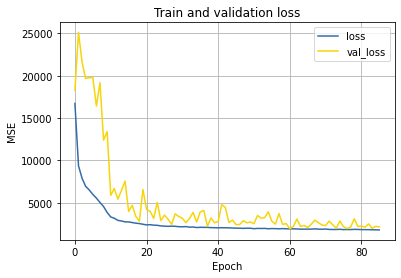

In [82]:
#dp.plot_loss(model_mlp_fit)

In [38]:
mlp_val_df = pd.DataFrame(mean_val)
#mlp_val_df.index = co2_val.index
mlp_val_df

0
0     556.990723
1     549.500549
2     556.375610
3     565.775879
4     571.694336
...          ...
6043  389.967865
6044  388.415314
6045  381.967072
6046  351.444763
6047  355.452850

[6048 rows x 1 columns]

In [39]:
co2_val.head()

21167    513.506720
21168    506.521267
21169    504.916659
21170    513.695182
21171    523.851760
Name: emission_factor, dtype: float64

In [40]:
lower_val

array([[502.5904068 ],
       [490.67334442],
       [505.53414307],
       ...,
       [355.15123672],
       [316.48031082],
       [324.50496063]])

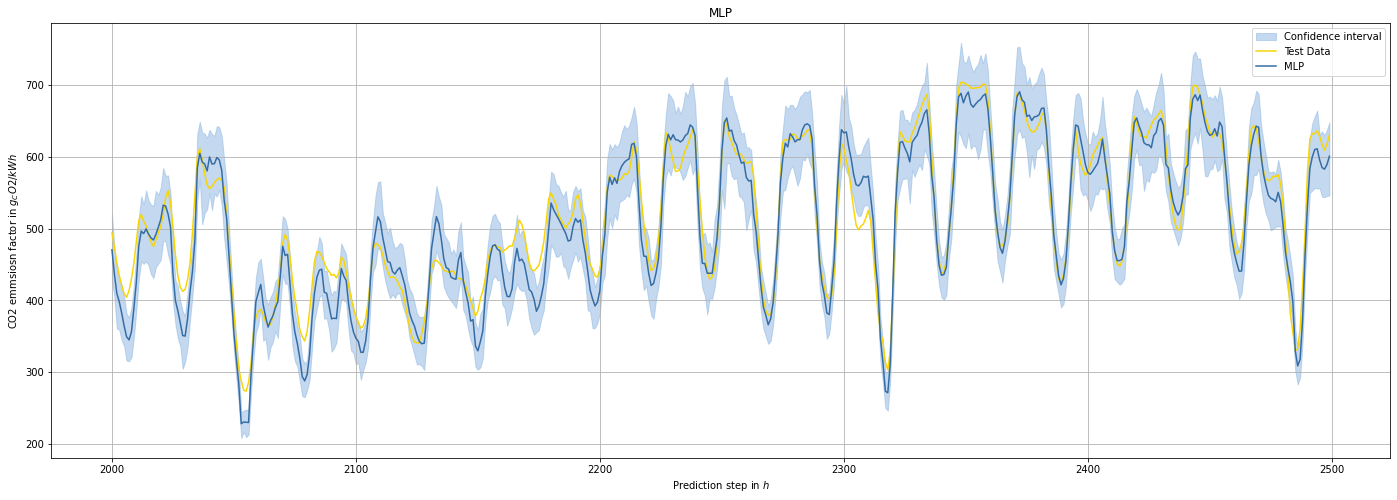

In [41]:
fun.plot_model_uncertainty(co2_val, mlp_val_df,lower_val[:,0],upper_val[:,0], slice_start = 2000, slice_end = 2500, method = 'MLP')

# walk forward testing

In [42]:
callback_test = keras.callbacks.EarlyStopping(
    monitor = 'loss',
    verbose = 0,
    patience = 15,
    mode = 'auto',
    restore_best_weights = True
)

In [43]:
learning_rate_test = 0.001
loss = 'mse'
optimizer = keras.optimizers.Adam(learning_rate_test)

In [46]:
alpha_low = 0.025
alpha_high = 0.975
lower_test, mean_test, upper_test, report_test = dp.walk_forward_deep_learning(tscv_test, model_mlp, co2, features, co2_test, alpha_low, alpha_high,n_features, callback_test ,learning_rate = learning_rate_test, loss = loss, optimizer = optimizer, batch_size =32, epochs = 10, num_preds = 100, method = 'CNN', refit = False, validation = True)
print(report_test)

Epoch 1/10
851/851 [==============================] - 7s 7ms/step - loss: 2154.0735 - val_loss: 1585.8914
Epoch 2/10
851/851 [==============================] - 6s 7ms/step - loss: 2165.4614 - val_loss: 2669.1104
Epoch 3/10
851/851 [==============================] - 6s 7ms/step - loss: 2086.9946 - val_loss: 2278.3660
Epoch 4/10
851/851 [==============================] - 6s 7ms/step - loss: 2055.6028 - val_loss: 2096.8154
Epoch 5/10
851/851 [==============================] - 6s 7ms/step - loss: 2074.9377 - val_loss: 2889.0735
Epoch 6/10
851/851 [==============================] - 6s 7ms/step - loss: 2159.5986 - val_loss: 3705.4717
Epoch 7/10
851/851 [==============================] - 6s 7ms/step - loss: 2101.0374 - val_loss: 3516.0261
Epoch 8/10
851/851 [==============================] - 6s 7ms/step - loss: 2069.6272 - val_loss: 3635.9722
Epoch 9/10
851/851 [==============================] - 6s 7ms/step - loss: 2035.7751 - val_loss: 2783.0176
Epoch 10/10
851/851 [=========================

In [81]:
print(mean_test)

In [82]:
print(co2_test)

27215    384.171132
27216    394.529970
27217    395.021625
27218    380.836436
27219    372.334296
            ...    
30234    510.849600
30235    581.149058
30236    624.367735
30237    630.314545
30238    619.932072
Name: emission_factor, Length: 3024, dtype: float64


In [30]:
mlp_test_df = pd.DataFrame(mean_test)
mlp_test_df.index = co2_test.index
mlp_test_df.head() 

0
27215  338.943512
27216  345.923584
27217  345.923584
27218  344.288940
27219  339.914185

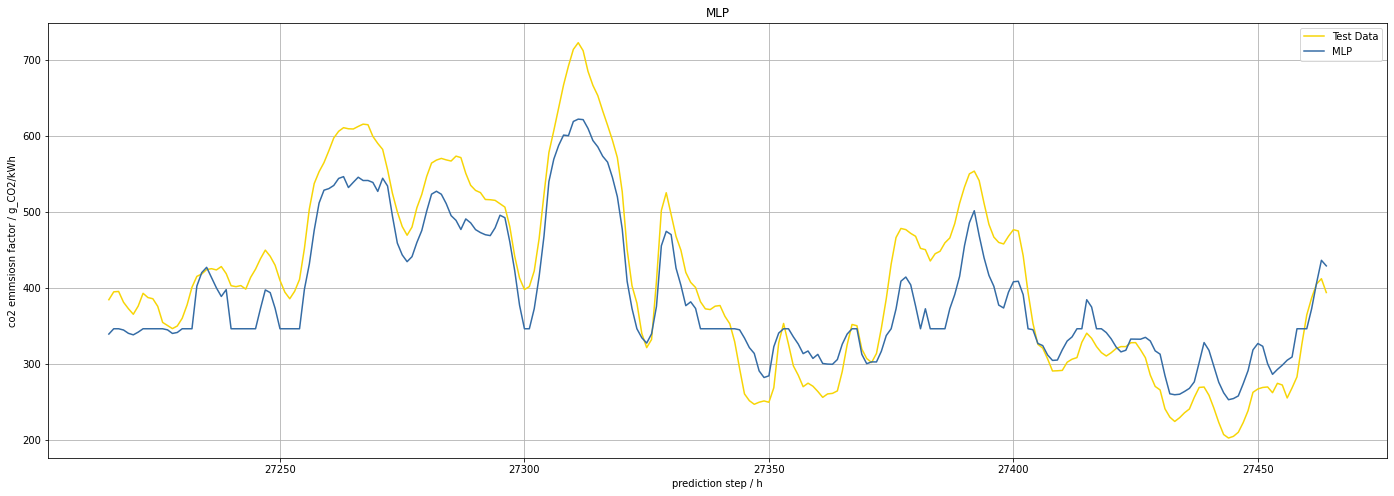

In [31]:
fun.plot_model(co2_test, mlp_test_df, slice_start = 0, slice_end = 250 , method = 'MLP')